In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(42)

def scatter_uv(U, V, title=""):
    plt.figure(figsize=(5,5))
    plt.scatter(U, V, s=6, alpha=0.35)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("U"); plt.ylabel("V")
    plt.title(title)
    plt.grid(alpha=0.2)
    plt.show()

def kendall_tau(U, V):
    return stats.kendalltau(U, V).correlation

def spearman_rho(U, V):
    return stats.spearmanr(U, V).correlation


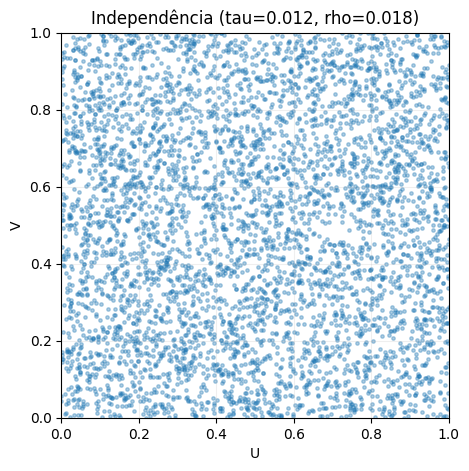

In [2]:
n = 5000
U = rng.random(n)
V = rng.random(n)

scatter_uv(U, V, f"Independência (tau={kendall_tau(U,V):.3f}, rho={spearman_rho(U,V):.3f})")


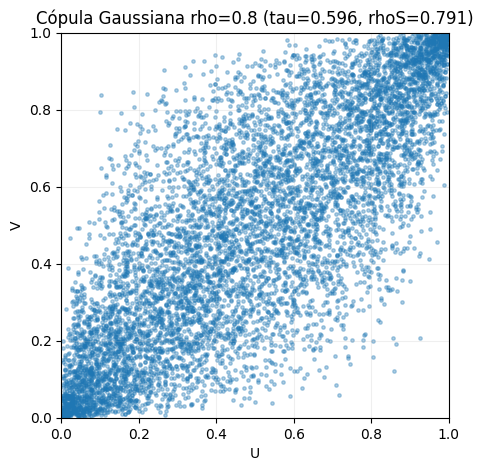

In [3]:
n = 8000
rho = 0.8

# amostra bivariada normal correlacionada
Z = rng.multivariate_normal([0,0], [[1, rho],[rho, 1]], size=n)
U = stats.norm.cdf(Z[:,0])
V = stats.norm.cdf(Z[:,1])

scatter_uv(U, V, f"Cópula Gaussiana rho={rho} (tau={kendall_tau(U,V):.3f}, rhoS={spearman_rho(U,V):.3f})")


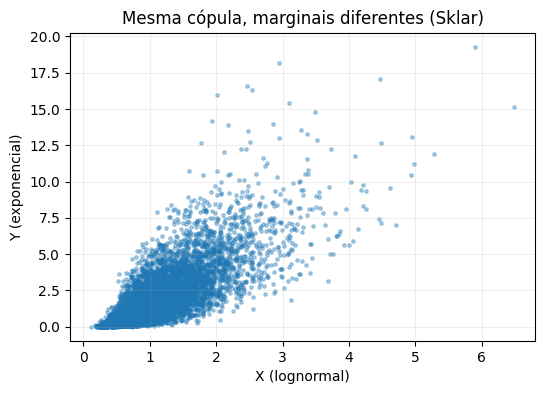

In [4]:
# use (U,V) da célula anterior (gaussiana), ou rode de novo
X = stats.lognorm(s=0.5, scale=np.exp(0)).ppf(U)   # Lognormal
Y = stats.expon(scale=2.0).ppf(V)                 # Exponencial

plt.figure(figsize=(6,4))
plt.scatter(X, Y, s=6, alpha=0.35)
plt.xlabel("X (lognormal)"); plt.ylabel("Y (exponencial)")
plt.title("Mesma cópula, marginais diferentes (Sklar)")
plt.grid(alpha=0.2)
plt.show()


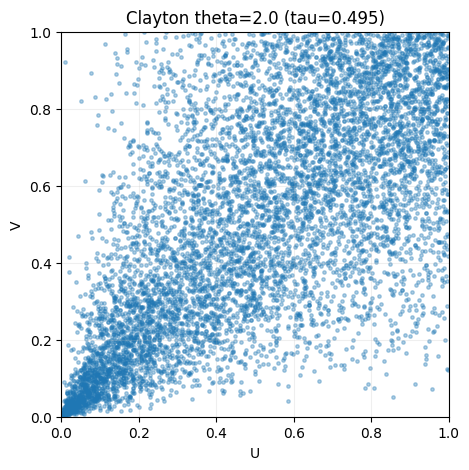

In [5]:
n = 8000
theta = 2.0  # >0

# Marshall–Olkin para Clayton:
# Se W ~ Gamma(1/theta, 1) e E1,E2 ~ Exp(1) indep,
# então U=(1+E1/W)^(-1/theta), V=(1+E2/W)^(-1/theta) tem Clayton(theta)
W  = rng.gamma(shape=1/theta, scale=1.0, size=n)
E1 = rng.exponential(scale=1.0, size=n)
E2 = rng.exponential(scale=1.0, size=n)

U = (1 + E1/W) ** (-1/theta)
V = (1 + E2/W) ** (-1/theta)

scatter_uv(U, V, f"Clayton theta={theta} (tau={kendall_tau(U,V):.3f})")


In [6]:
def joint_lower_tail_prob(U, V, alpha=0.05):
    return np.mean((U < alpha) & (V < alpha))

alphas = [0.20, 0.10, 0.05, 0.02, 0.01]
print("alpha | P(U<alpha, V<alpha)")
for a in alphas:
    print(f"{a:5.2f} | {joint_lower_tail_prob(U,V,a):.4f}")


alpha | P(U<alpha, V<alpha)
 0.20 | 0.1394
 0.10 | 0.0704
 0.05 | 0.0366
 0.02 | 0.0141
 0.01 | 0.0076


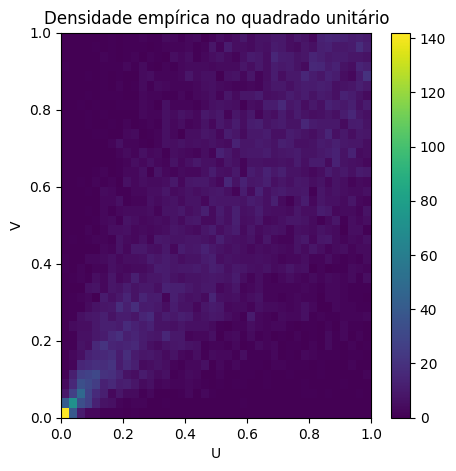

In [7]:
plt.figure(figsize=(5,5))
plt.hist2d(U, V, bins=40)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("U"); plt.ylabel("V")
plt.title("Densidade empírica no quadrado unitário")
plt.colorbar()
plt.show()


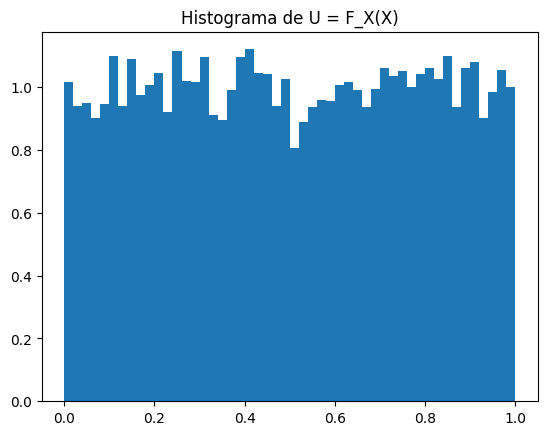

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(0)

# X qualquer
X = rng.lognormal(mean=0, sigma=1, size=10000)

# Transformação integral
U = stats.lognorm(s=1).cdf(X)

plt.hist(U, bins=50, density=True)
plt.title("Histograma de U = F_X(X)")
plt.show()


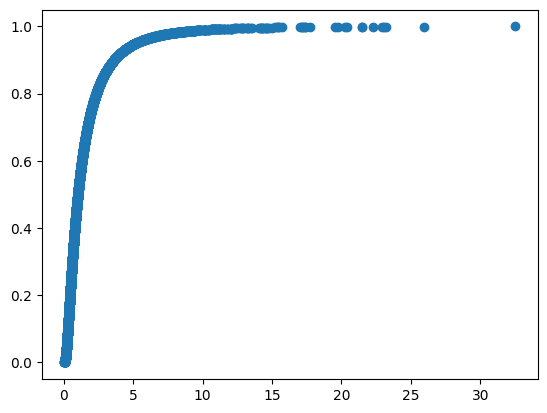

In [9]:
plt.scatter(X, U)

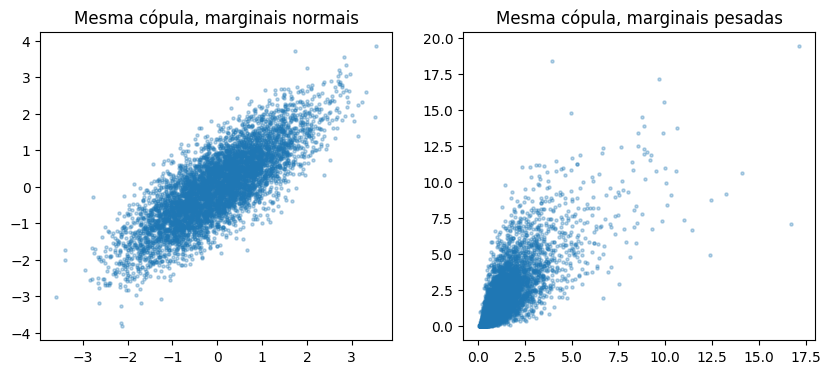

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(0)
n = 6000
rho = 0.8

# Copula gaussiana
Z = rng.multivariate_normal([0,0], [[1,rho],[rho,1]], size=n)
U = stats.norm.cdf(Z[:,0])
V = stats.norm.cdf(Z[:,1])

# Marginais A
X1 = stats.norm.ppf(U)
Y1 = stats.norm.ppf(V)

# Marginais B (caudas pesadas)
X2 = stats.lognorm(s=0.8).ppf(U)
Y2 = stats.expon(scale=2).ppf(V)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X1, Y1, s=5, alpha=0.3)
ax[0].set_title("Mesma cópula, marginais normais")

ax[1].scatter(X2, Y2, s=5, alpha=0.3)
ax[1].set_title("Mesma cópula, marginais pesadas")

plt.show()


Copula: Gaussiana (rho=0.6) | n=200000
Marginais A: Normal(0,1)  ->  VaR99(S)=4.160 | ES99(S)=4.773 | P(extremo conjunto)=0.00193
Marginais B: t(df=3)     ->  VaR99(S)=8.067 | ES99(S)=12.015 | P(extremo conjunto)=0.00193


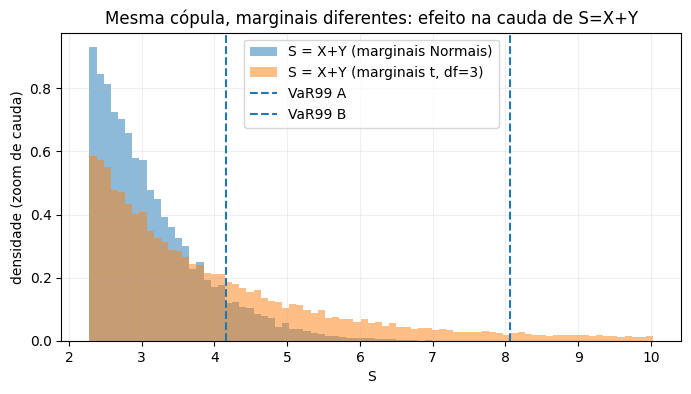

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(7)
n = 200_000
rho = 0.6
alpha = 0.99  # VaR/ES nível 99%

# --- 1) Mesma cópula (Gaussiana) -> (U,V) uniformes com dependência ---
Z = rng.multivariate_normal([0,0], [[1,rho],[rho,1]], size=n)
U = stats.norm.cdf(Z[:,0])
V = stats.norm.cdf(Z[:,1])

# --- 2) Duas escolhas de marginais ---
# A) marginais leves (Normal)
X_A = stats.norm(loc=0, scale=1).ppf(U)
Y_A = stats.norm(loc=0, scale=1).ppf(V)

# B) marginais pesadas (t-Student com poucos graus de liberdade)
df = 3
X_B = stats.t(df=df, loc=0, scale=1).ppf(U)
Y_B = stats.t(df=df, loc=0, scale=1).ppf(V)

# Somas (portfólio / loss aggregate)
S_A = X_A + Y_A
S_B = X_B + Y_B

def var_es(x, a=0.99):
    q = np.quantile(x, a)
    es = x[x >= q].mean()
    return q, es

VaR_A, ES_A = var_es(S_A, alpha)
VaR_B, ES_B = var_es(S_B, alpha)

# Probabilidade de extremos conjuntos: ambos acima do quantil alpha de cada marginal
qXA = np.quantile(X_A, alpha); qYA = np.quantile(Y_A, alpha)
qXB = np.quantile(X_B, alpha); qYB = np.quantile(Y_B, alpha)
p_joint_A = np.mean((X_A >= qXA) & (Y_A >= qYA))
p_joint_B = np.mean((X_B >= qXB) & (Y_B >= qYB))

print(f"Copula: Gaussiana (rho={rho}) | n={n}")
print(f"Marginais A: Normal(0,1)  ->  VaR{int(alpha*100)}(S)={VaR_A:.3f} | ES{int(alpha*100)}(S)={ES_A:.3f} | P(extremo conjunto)={p_joint_A:.5f}")
print(f"Marginais B: t(df={df})     ->  VaR{int(alpha*100)}(S)={VaR_B:.3f} | ES{int(alpha*100)}(S)={ES_B:.3f} | P(extremo conjunto)={p_joint_B:.5f}")

# Visual: cauda direita de S (zoom)
plt.figure(figsize=(8,4))
bins = np.linspace(np.quantile(S_A, 0.90), np.quantile(S_B, 0.995), 80)
plt.hist(S_A, bins=bins, density=True, alpha=0.5, label="S = X+Y (marginais Normais)")
plt.hist(S_B, bins=bins, density=True, alpha=0.5, label=f"S = X+Y (marginais t, df={df})")
plt.axvline(VaR_A, linestyle="--", label=f"VaR{int(alpha*100)} A")
plt.axvline(VaR_B, linestyle="--", label=f"VaR{int(alpha*100)} B")
plt.title("Mesma cópula, marginais diferentes: efeito na cauda de S=X+Y")
plt.xlabel("S")
plt.ylabel("densidade (zoom de cauda)")
plt.grid(alpha=0.2)
plt.legend()
plt.show()


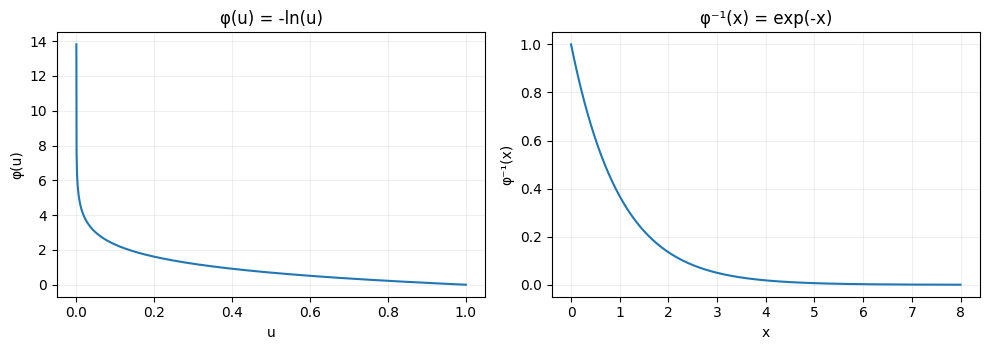

In [12]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(1e-6, 1, 2000)
phi = lambda u: -np.log(u)
phi_inv = lambda x: np.exp(-x)

plt.figure(figsize=(10,3.6))
plt.subplot(1,2,1); plt.plot(t, phi(t)); plt.title("φ(u) = -ln(u)"); plt.grid(alpha=0.2); plt.xlabel("u"); plt.ylabel("φ(u)")
x = np.linspace(0, 8, 2000)
plt.subplot(1,2,2); plt.plot(x, phi_inv(x)); plt.title("φ⁻¹(x) = exp(-x)"); plt.grid(alpha=0.2); plt.xlabel("x"); plt.ylabel("φ⁻¹(x)")
plt.tight_layout(); plt.show()


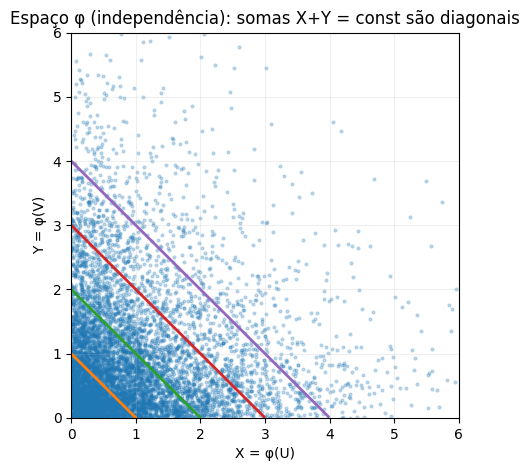

In [13]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
n = 8000
U = rng.random(n); V = rng.random(n)

X = -np.log(U); Y = -np.log(V)  # espaço φ

plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=4, alpha=0.25)
plt.xlabel("X = φ(U)"); plt.ylabel("Y = φ(V)")
plt.title("Espaço φ (independência): somas X+Y = const são diagonais")
plt.grid(alpha=0.2)

# algumas retas X+Y=c
cs = [0.5, 1, 2, 3, 4]
xx = np.linspace(0, 6, 200)
for c in cs:
    yy = c - xx
    m = (yy >= 0)
    plt.plot(xx[m], yy[m], linewidth=2)

plt.xlim(0,6); plt.ylim(0,6)
plt.show()


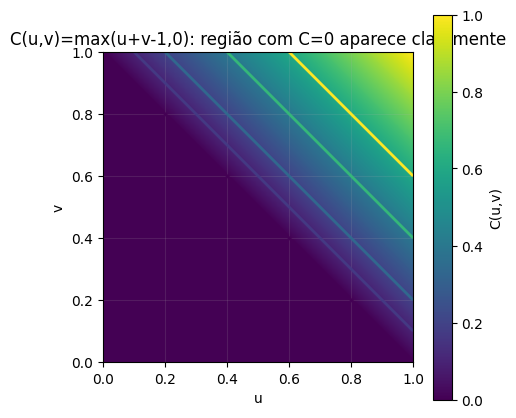

In [14]:
import numpy as np
import matplotlib.pyplot as plt

phi = lambda u: 1 - u
phi_inv = lambda x: 1 - x

# grade no quadrado unitário
g = 250
u = np.linspace(0,1,g)
v = np.linspace(0,1,g)
U, V = np.meshgrid(u, v)

C = np.maximum(U + V - 1, 0)  # cópula "linear"

plt.figure(figsize=(5,5))
plt.imshow(C, origin="lower", extent=[0,1,0,1], aspect="equal")
plt.colorbar(label="C(u,v)")
plt.contour(U, V, C, levels=[0.0, 0.1, 0.2, 0.4, 0.6], linewidths=2)
plt.title("C(u,v)=max(u+v-1,0): região com C=0 aparece claramente")
plt.xlabel("u"); plt.ylabel("v")
plt.grid(alpha=0.15)
plt.show()


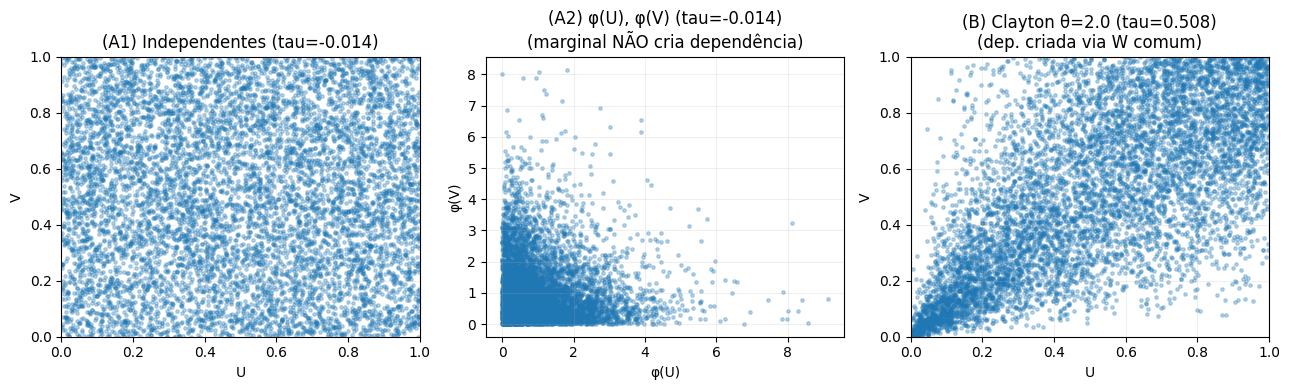

Resumo:
  Independentes:            tau(U,V)      = -0.0145
  Após transformar margens: tau(φ(U),φ(V))= -0.0145  (continua ~0)
  Clayton (dep. real):      tau(U,V)      = 0.5080


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(0)
n = 8000

# -------------------------
# (A) U,V independentes
# -------------------------
U0 = rng.random(n)
V0 = rng.random(n)

# Transformação marginal com uma geradora (ex.: φ(u)=-ln u)
phi = lambda u: -np.log(u)

X0 = phi(U0)
Y0 = phi(V0)

# Tau (deve ficar ~0 nos dois casos)
tau_uv  = stats.kendalltau(U0, V0).correlation
tau_xy  = stats.kendalltau(X0, Y0).correlation

# -------------------------
# (B) Agora "criando dependência" via uma Archimedean (Clayton)
# Clayton: usa variável latente W comum (Marshall–Olkin)
# -------------------------
theta = 2.0  # > 0
W  = rng.gamma(shape=1/theta, scale=1.0, size=n)
E1 = rng.exponential(scale=1.0, size=n)
E2 = rng.exponential(scale=1.0, size=n)

U1 = (1 + E1/W) ** (-1/theta)
V1 = (1 + E2/W) ** (-1/theta)

tau_clay = stats.kendalltau(U1, V1).correlation

# -------------------------
# Plots
# -------------------------
fig, ax = plt.subplots(1, 3, figsize=(13,4))

ax[0].scatter(U0, V0, s=6, alpha=0.30)
ax[0].set_title(f"(A1) Independentes (tau={tau_uv:.3f})")
ax[0].set_xlim(0,1); ax[0].set_ylim(0,1)
ax[0].set_xlabel("U"); ax[0].set_ylabel("V")
ax[0].grid(alpha=0.2)

ax[1].scatter(X0, Y0, s=6, alpha=0.30)
ax[1].set_title(f"(A2) φ(U), φ(V) (tau={tau_xy:.3f})\n(marginal NÃO cria dependência)")
ax[1].set_xlabel("φ(U)"); ax[1].set_ylabel("φ(V)")
ax[1].grid(alpha=0.2)

ax[2].scatter(U1, V1, s=6, alpha=0.30)
ax[2].set_title(f"(B) Clayton θ={theta} (tau={tau_clay:.3f})\n(dep. criada via W comum)")
ax[2].set_xlim(0,1); ax[2].set_ylim(0,1)
ax[2].set_xlabel("U"); ax[2].set_ylabel("V")
ax[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()

print("Resumo:")
print(f"  Independentes:            tau(U,V)      = {tau_uv:.4f}")
print(f"  Após transformar margens: tau(φ(U),φ(V))= {tau_xy:.4f}  (continua ~0)")
print(f"  Clayton (dep. real):      tau(U,V)      = {tau_clay:.4f}")
